In [35]:
from astropy.io import fits
import os
import scipy.stats as stats
from sklearn import preprocessing
import shutil
from astropy.timeseries import LombScargle
import numpy as np
import matplotlib.pyplot as plt
from PyAstronomy import pyasl
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler, SplineInterpolatedResampler
from astropy import units as u
from specutils import Spectrum1D
from lmfit import Parameters, minimize, report_fit, Model,fit_report
from pylab import rc
from matplotlib import transforms
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.coordinates import ICRS
plt.rc('xtick',c='w')
plt.rc('ytick',c='w')
from astropy.units import cds
cds.enable()
from astropy.constants import G
from mpl_toolkits import mplot3d

In [2]:
M_WD = 1.0281888484491258e+30#(0.517091*u.solMass).to('kg')
M_BD = 1.0439685285348278e+29#55*cds.jovMass.to('kg')
Per = 5*60*60
GConst = 6.6743e-11

In [3]:
inc = np.linspace(0, np.pi/2, 1000)
K_array = np.cbrt((2*np.pi*GConst*(M_BD**3)*np.sin(inc)*np.sin(inc)*np.sin(inc))/((M_WD+M_BD)*(M_WD+M_BD)*Per))
K_array = K_array/1000

(0, 27.44170255536521)

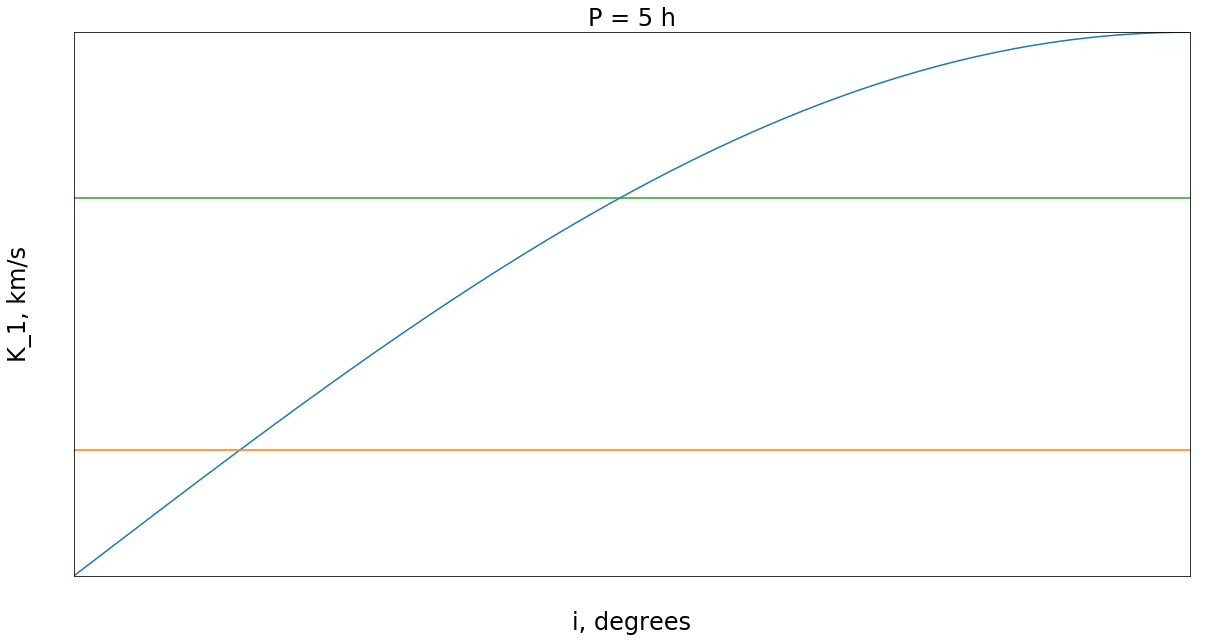

In [4]:
plt.figure(figsize=(20,10))
plt.plot(np.degrees(inc), K_array)
plt.ylabel('K_1, km/s', c='k', fontsize=24)
plt.xlabel('i, degrees', c='k', fontsize=24)
plt.plot([0,90], [6.364037567208462,6.364037567208462])
plt.plot([0,90], [3*6.364037567208462,3*6.364037567208462])
plt.tick_params(axis='both', which='major', labelsize=24)
plt.title('P = 5 h', fontsize=24)
plt.xlim(0,90)
plt.ylim(0,max(K_array))
#plt.savefig('gd1400_5h.pdf')

(0, 37.244120422820394)

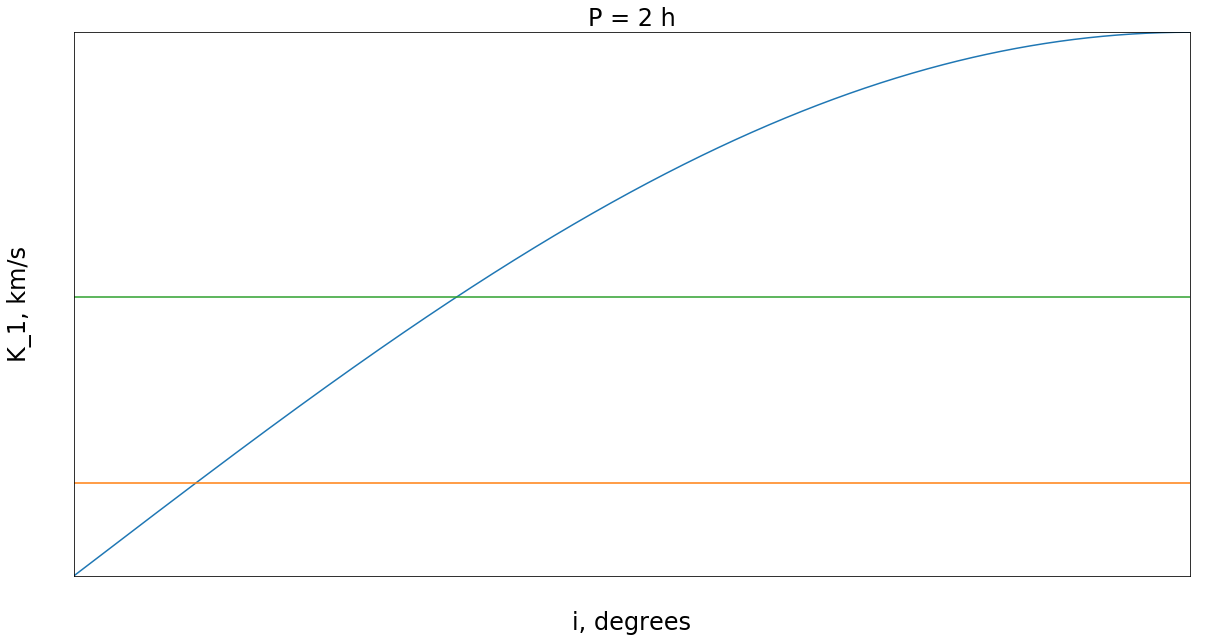

In [5]:
M_WD = 1.0281888484491258e+30#(0.517091*u.solMass).to('kg')
M_BD = 1.0439685285348278e+29#55*cds.jovMass.to('kg')
Per = 2*60*60
GConst = 6.6743e-11
inc = np.linspace(0, np.pi/2, 1000)
K_array = np.cbrt((2*np.pi*GConst*(M_BD**3)*np.sin(inc)*np.sin(inc)*np.sin(inc))/((M_WD+M_BD)*(M_WD+M_BD)*Per))
K_array = K_array/1000
plt.figure(figsize=(20,10))
plt.plot(np.degrees(inc), K_array)
plt.ylabel('K_1, km/s', c='k', fontsize=24)
plt.xlabel('i, degrees', c='k', fontsize=24)
plt.plot([0,90], [6.364037567208462,6.364037567208462])
plt.plot([0,90], [3*6.364037567208462,3*6.364037567208462])
plt.tick_params(axis='both', which='major', labelsize=24)
plt.title('P = 2 h', fontsize=24)
plt.xlim(0,90)
plt.ylim(0,max(K_array))
#plt.savefig('gd1400_2h.pdf')

In [19]:
K_array

array([ 0.        ,  0.05856146,  0.11712279,  0.17568382,  0.23424441,
        0.29280443,  0.35136372,  0.40992215,  0.46847956,  0.52703581,
        0.58559076,  0.64414426,  0.70269617,  0.76124634,  0.81979463,
        0.8783409 ,  0.93688499,  0.99542676,  1.05396608,  1.11250279,
        1.17103674,  1.22956781,  1.28809583,  1.34662067,  1.40514218,
        1.46366021,  1.52217463,  1.58068528,  1.63919203,  1.69769472,
        1.75619322,  1.81468737,  1.87317704,  1.93166207,  1.99014233,
        2.04861767,  2.10708794,  2.16555301,  2.22401272,  2.28246693,
        2.3409155 ,  2.39935829,  2.45779514,  2.51622591,  2.57465046,
        2.63306865,  2.69148033,  2.74988535,  2.80828357,  2.86667485,
        2.92505905,  2.98343601,  3.0418056 ,  3.10016766,  3.15852206,
        3.21686866,  3.27520729,  3.33353784,  3.39186014,  3.45017405,
        3.50847943,  3.56677614,  3.62506404,  3.68334296,  3.74161279,
        3.79987336,  3.85812454,  3.91636618,  3.97459813,  4.03

(0, 21.780493752092582)

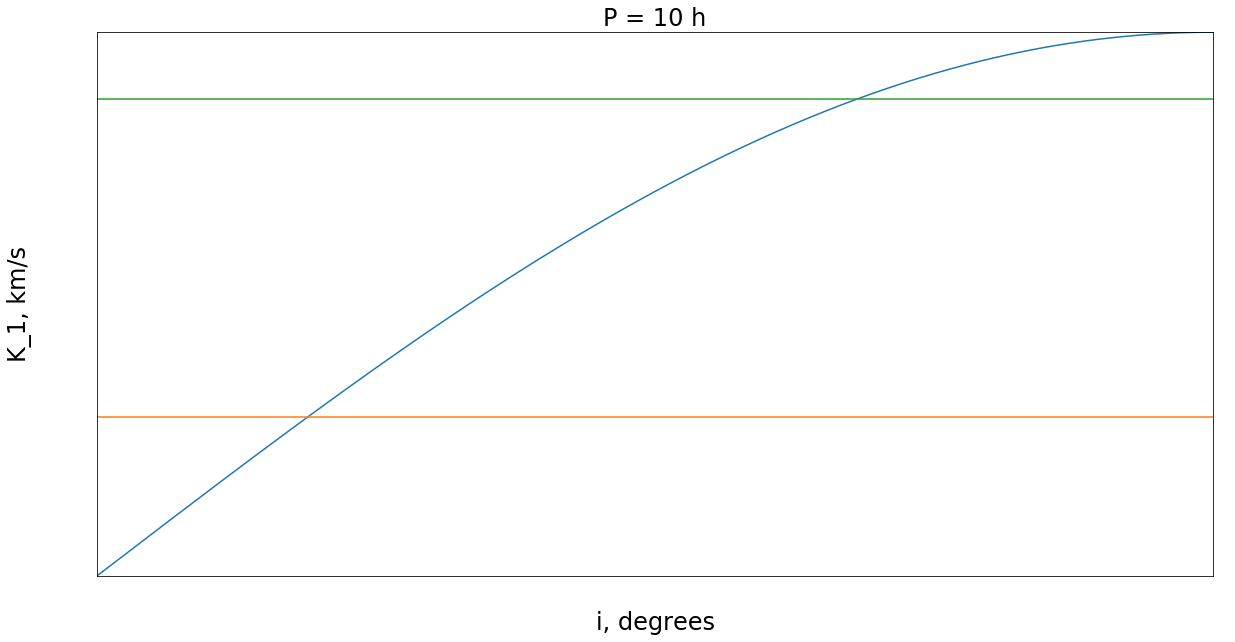

In [6]:
M_WD = 1.0281888484491258e+30#(0.517091*u.solMass).to('kg')
M_BD = 1.0439685285348278e+29#55*cds.jovMass.to('kg')
Per = 10*60*60
GConst = 6.6743e-11
inc = np.linspace(0, np.pi/2, 1000)
K_array = np.cbrt((2*np.pi*GConst*(M_BD**3)*np.sin(inc)*np.sin(inc)*np.sin(inc))/((M_WD+M_BD)*(M_WD+M_BD)*Per))
K_array = K_array/1000
plt.figure(figsize=(20,10))
plt.plot(np.degrees(inc), K_array)
plt.ylabel('K_1, km/s', c='k', fontsize=24)
plt.xlabel('i, degrees', c='k', fontsize=24)
plt.plot([0,90], [6.364037567208462,6.364037567208462])
plt.plot([0,90], [3*6.364037567208462,3*6.364037567208462])
plt.tick_params(axis='both', which='major', labelsize=24)
plt.title('P = 10 h', fontsize=24)
plt.xlim(0,90)
plt.ylim(0,max(K_array))
#plt.savefig('gd1400_10h.pdf')

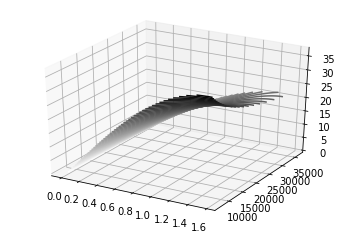

In [29]:
def f(Per, inc):
    return np.cbrt((2*np.pi*GConst*(M_BD**3)*np.sin(inc)*np.sin(inc)*np.sin(inc))/((M_WD+M_BD)*(M_WD+M_BD)*Per))/1000

incs = np.linspace(0, np.pi/2, 100)
Per = np.linspace(2*60*60, 10*60*60, 100)

X, Y = np.meshgrid(incs, Per)
Z = f(Y, X)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')

In [9]:
M_BD

1.0439685285348278e+29

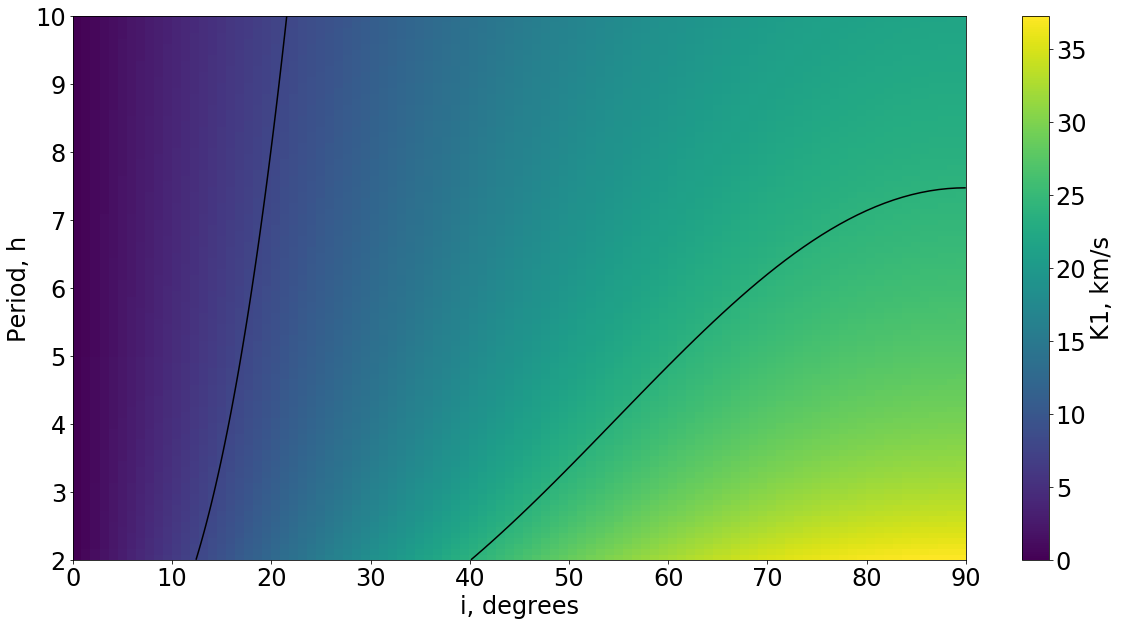

In [8]:
def f(Per, inc):
    return np.cbrt((2*np.pi*GConst*(M_BD**3)*np.sin(inc)*np.sin(inc)*np.sin(inc))/((M_WD+M_BD)*(M_WD+M_BD)*Per))/1000
plt.rc('xtick',c='k')
plt.rc('ytick',c='k')
incs = np.linspace(0, np.pi/2, 100)
Per = np.linspace(2*60*60, 10*60*60, 100)

X, Y = np.meshgrid(incs, Per)
Z = f(Y, X)
#Z[Z<3*6.364037567208462] = -9999
#Z[Z<6.364037567208462] = -99
Y = Y/60/60
X = np.degrees(X)

plt.figure(figsize=(20,10))
pc = plt.pcolormesh(X,Y,Z)
plt.contour(X, Y, Z, levels = [8,24], colors='k')
plt.ylabel('Period, h', c='k', fontsize=24)
plt.xlabel('i, degrees', c='k', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
cbar = plt.colorbar(pc)
cbar.ax.tick_params(labelsize=24)
cbar.set_label('K1, km/s',size=24)
#plt.savefig('pg0010MapK1.pdf')

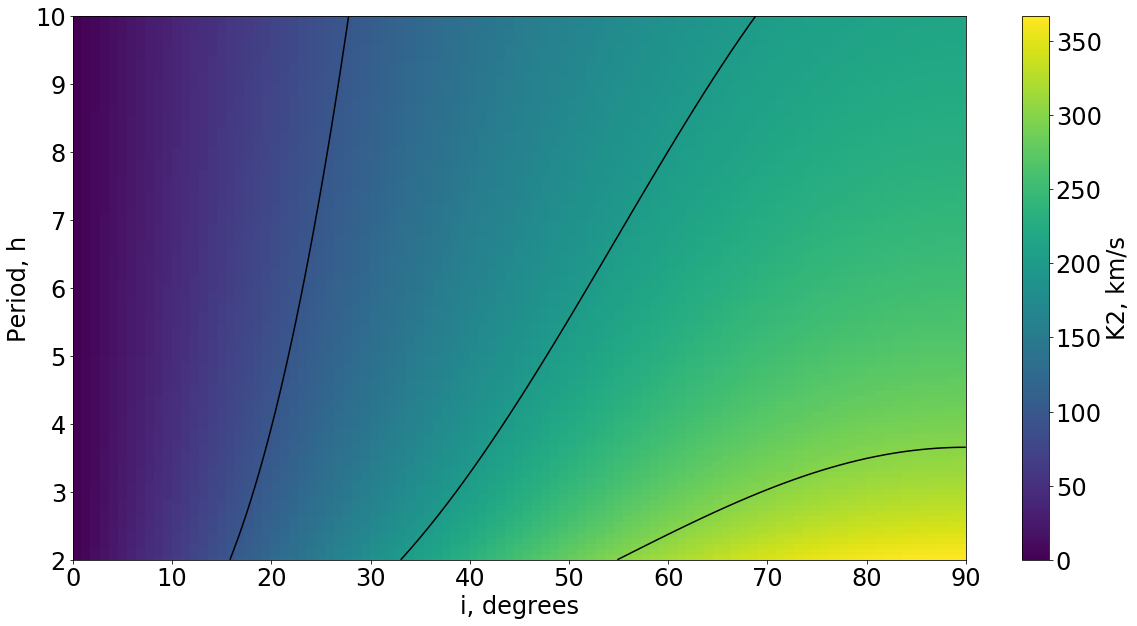

In [12]:
def f(Per, inc):
    return np.cbrt((2*np.pi*GConst*(M_WD**3)*np.sin(inc)*np.sin(inc)*np.sin(inc))/((M_WD+M_BD)*(M_WD+M_BD)*Per))/1000
plt.rc('xtick',c='k')
plt.rc('ytick',c='k')
incs = np.linspace(0, np.pi/2, 100)
Per = np.linspace(2*60*60, 10*60*60, 100)

X, Y = np.meshgrid(incs, Per)
Z = f(Y, X)
#Z[Z<3*6.364037567208462] = -9999
#Z[Z<6.364037567208462] = -99
Y = Y/60/60
X = np.degrees(X)

plt.figure(figsize=(20,10))
pc = plt.pcolormesh(X,Y,Z)
plt.contour(X, Y, Z, levels = [100,200,300], colors='k')
plt.ylabel('Period, h', c='k', fontsize=24)
plt.xlabel('i, degrees', c='k', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
cbar = plt.colorbar(pc)
cbar.ax.tick_params(labelsize=24)
cbar.set_label('K2, km/s',size=24)
plt.savefig('pg0010MapK2.pdf')

In [20]:
gracesRV = [34.65243555, 37.12815555, 37.46837681, 38.50375322, 44.33313464, 35.97130398,
 17.00744901, 36.02458101, 37.12030251, 37.94672298, 31.23498605, 40.26181678]
#17
uvesRV = [36.72642376, 36.92624317, 36.42188325, 29.1531653,  40.18564586, 36.58059808, 38.65595438, 37.31291876]


In [21]:
expectedGr = np.mean(gracesRV)
chiGr = 0
for el in gracesRV:
    chi = (el - expectedGr)**2/expectedGr
    chiGr = chiGr + chi
    
p_value = 1 - stats.norm.cdf(chiGr, len(gracesRV) - 1)
        
print("chisquare-score is:", chiGr, " and p value is:", p_value)

chisquare-score is: 13.637552015510655  and p value is: 0.004175340881206746


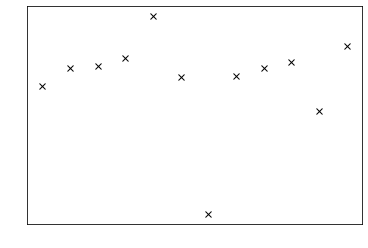

In [22]:
plt.plot(gracesRV, 'kx')

In [23]:
expectedUv = np.mean(uvesRV)
chiUV = 0
for el in uvesRV:
    chi = (el - expectedUv)**2/expectedUv
    chiUV = chiUV + chi
    
p_value = 1 - stats.norm.cdf(chiUV, len(uvesRV) - 1)
        
print("chisquare-score is:", chiUV, " and p value is:", p_value)

chisquare-score is: 2.003387010086082  and p value is: 0.9999997082700236


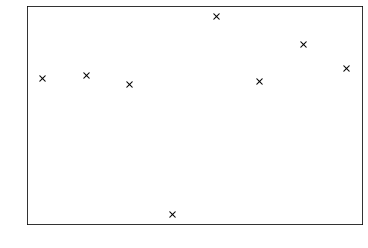

In [24]:
plt.plot(uvesRV, 'kx')

In [7]:
#M_WD = (0.517091*u.solMass).to('kg')
M_dw = 1.0281888e+30 #kg
M_sol = 1.988409870698051e+30 #kg
R_sol = 695700000.0 # m

In [11]:
R = R_sol*0.01*((M_sol/M_dw)**(1/3))
delLam = 6562.801*6.6743e-11*M_dw/(300000000*300000000*R)
print(delLam)

0.5773320063594266


In [12]:
core = 6563.919098070346
shift = delLam
emis = 6562.790

emis + delLam

6563.367332006359

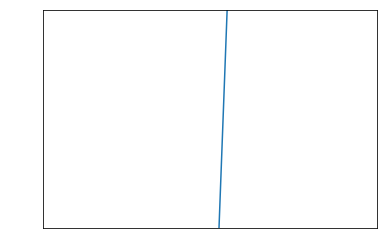

In [40]:
Porb = 10*60*60*u.s
K1 = 23*u.km/u.s
GravConstant = 6.67408e-11*u.m*u.m*u.m/u.kg/u.second/u.second# m3kg-1s-2
sin = 0.7880107536
RHS = Porb*K1*K1*K1/(2*np.pi*GravConstant*sin*sin*sin)
M_BD = np.linspace(0,100,1000)*u.M_jup
M_WD = 0.515981*u.M_sun
plt.ylim(0,0.01)
plt.xlim(70,80)
plt.plot(M_BD, ((M_BD*M_BD*M_BD/((M_BD+M_WD)*(M_BD+M_WD)))-RHS))

In [2]:
def weightedMean(RVs, Errs):
    sumN = 0
    sumD = 0
    for count, el in enumerate(RVs):
        tmpN = el/(Errs[count]*Errs[count])
        tmpD = 1/(Errs[count]*Errs[count])
        sumN = sumN+tmpN
        sumD = sumD+tmpD
    return sumN/sumD, np.sqrt(1/sumD)

def chi(RVs, Errs, meanW):
    sumC = 0
    for count, el in enumerate(RVs):
        tmp = (el-meanW)*(el-meanW)/(Errs[count]*Errs[count])
        sumC = sumC+tmp
    return 1-stats.chi2.cdf(sumC, len(RVs)-1)

In [ ]:
hiresDates = [56552.29983796,56552.32824074, 56555.297305, 56555.318738]
hiresRV = [41.14701052,43.87079741, 38.6788224, 46.2566111]
hiresErr = np.array([1.082851234999998,1.3853121349999995, 2.3790465949999984, 2.5507801299999997])

#updated
intDates = np.array([2457233.71501668,2457233.73246731,2457234.71345457,2457234.73090418,2457235.72522182,2457235.74296146])-2400000.5
intRV = [64.61,51.08,25.43,41.90,39.04,33.86]
intErr = [13.48,13.23,13.40,13.89,11.38,12.22]
MMTDates = [57402.12835648, 57402.13734954, 57402.17362269, 57402.18121528]
MMTRV = [46.9865816,45.07613055,53.68306775,45.19561851]
MMTErr = 2*np.array([3.5163078887897057,3.5163078887897057,3.5163078887897057,3.5163078887897057])

#updated
uvesDates = [58048.09070358, 58048.09886905, 58049.0627518 , 58049.07092421,58072.02603352, 58072.03420339, 58075.02419151, 58075.03236158]
uvesRV = [35.39198661,37.6502475,39.47297919,27.84297005,38.40584637,34.52883699,37.47951113,35.79765149]
uvesErr = [3.4596511360990725,1.891875400960373,3.3525875023780856,3.6755326138707787,1.4798032513800585,1.7342073973913443,1.50831170400485,2.211585964741186]

#updated
gracesDates = [58797.25473013888,58797.277137789344,58797.299510231474,58798.26375721064,58798.286202488416,58798.30861703703,58799.228049699064,58799.25002996527,58799.27210225693,58799.43184746527,58799.45434912036,58799.47681873842]
gracesRV = [32.56748658,37.87207732,36.27249953,30.91676393,31.07605008,33.36337962,37.35398777,35.42758838,33.74046928,38.98547846,33.42640273,33.89676935]
gracesErr = [4.414593217007518,3.7177354597533494,2.571942440083486,3.5429181193511745,4.409190315573703,2.584673492283166,13.161937171420849,2.671273425061141,2.1529680031968788,1.924350433729881,3.0082177847190863,3.166156141189635]

#updated
whtDates = [58359.09057667, 58359.09767667, 58359.10499667, 58359.11207667,58359.11917667, 58359.12626667, 58359.13983667, 58359.14692667,58359.15402667, 58359.16111667, 58359.16820667, 58362.20097667,58364.17251667]
whtErr = [13.201683299869117,16.62772567871703,35.962024836721,15.382930281061615,30.149172933928114,17.02743062291526,17.290093871952095,19.791104808528107,8.696437571669362,12.436533835247424,10.818299818299538,30.76586056212323,18.774712236134757]
whtRV = [28.72430892,25.05172552,45.13232332,26.38494572,44.18188865,36.85449908,42.75754913,25.83728422,42.72068892,28.9982501,34.00498353,21.87038074,44.48459442]
allallT = np.concatenate((hiresDates,intDates,MMTDates,uvesDates,gracesDates,whtDates))
allallRV = np.concatenate((hiresRV,intRV,MMTRV, uvesRV,gracesRV, whtRV))
allallErr = np.concatenate((hiresErr,intErr,MMTErr,uvesErr,gracesErr, whtErr))



meanW, MeanErr = weightedMean(hiresRV, hiresErr)
print('Hires = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(hiresRV, hiresErr, meanW))

meanW, MeanErr = weightedMean(intRV, intErr)
print('INT = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(intRV, intErr, meanW))

meanW, MeanErr = weightedMean(MMTRV, MMTErr)
print('MMT = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(MMTRV, MMTErr, meanW))

meanW, MeanErr = weightedMean(uvesRV, uvesErr)
print('UVES = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(uvesRV, uvesErr, meanW))

meanW, MeanErr = weightedMean(gracesRV, gracesErr)
print('GRACES = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(gracesRV, gracesErr, meanW))

meanW, MeanErr = weightedMean(whtRV, whtErr)
print('WHT = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(whtRV, whtErr, meanW))

meanW, MeanErr = weightedMean(allallRV, allallErr)
print('All = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(allallRV, allallErr, meanW))


allallRV = np.concatenate((uvesRV,gracesRV, whtRV))
allallErr = np.concatenate((uvesErr,gracesErr, whtErr))

meanW, MeanErr = weightedMean(allallRV, allallErr)
print('The same systematic velocity = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(allallRV, allallErr, meanW))

allallRV = np.concatenate((uvesRV,gracesRV, whtRV, MMTRV))
allallErr = np.concatenate((uvesErr,gracesErr, whtErr, MMTErr))

meanW, MeanErr = weightedMean(allallRV, allallErr)
print('The same systematic velocity + MMT = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(allallRV, allallErr, meanW))

allallRV = np.concatenate((uvesRV,gracesRV, whtRV, np.array(MMTRV)-4.2))
allallErr = np.concatenate((uvesErr,gracesErr, whtErr, MMTErr))

meanW, MeanErr = weightedMean(allallRV, allallErr)
print('The same systematic velocity + MMT corrected = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(allallRV, allallErr, meanW))


allallRV = np.concatenate((uvesRV,gracesRV, whtRV, intRV))
allallErr = np.concatenate((uvesErr,gracesErr, whtErr, intErr))

meanW, MeanErr = weightedMean(allallRV, allallErr)
print('The same systematic velocity + INT = ', meanW, ' +- ', MeanErr, 'km/s; p-value = ',chi(allallRV, allallErr, meanW))



In [30]:

uvesErr = [3.4596511360990725,1.891875400960373,3.3525875023780856,3.6755326138707787,1.4798032513800585,1.7342073973913443,1.50831170400485,2.211585964741186]

gracesErr = [4.414593217007518,3.7177354597533494,2.571942440083486,3.5429181193511745,4.409190315573703,2.584673492283166,13.161937171420849,2.671273425061141,2.1529680031968788,1.924350433729881,3.0082177847190863,3.166156141189635]

whtErr = [13.201683299869117,16.62772567871703,35.962024836721,15.382930281061615,30.149172933928114,17.02743062291526,17.290093871952095,19.791104808528107,8.696437571669362,12.436533835247424,10.818299818299538,30.76586056212323,18.774712236134757]

intErr = [13.48,13.23,13.40,13.89,11.38,12.22]
obsErr = np.concatenate((uvesErr,gracesErr,whtErr,intErr))
def mainMethod(period, simN):
    GravConstant = 6.67408e-20
    M2 = 25*1.8981245973360505e27
    dates = np.concatenate((uvesDates, gracesDates,whtDates, intDates))
    twoSigma = 10.02983388029134
    errors = np.ones_like(dates)*twoSigma
    M1 = 0.569*(1.988409870698051e30)
    Porb = period*60*60
    orbitalSeparation = np.cbrt((M2+M1)*GravConstant*Porb*Porb/(4*np.pi*np.pi))
    v_orb = 2*np.pi*orbitalSeparation/Porb # km/s keplerian velocity of the white dwarf
    failed = []
    for i in range(simN):
        Amp = (v_orb*(M2/M1))*np.sin(0.903339111)
        ys = Amp*np.sin(np.array(dates)*(1/(period/24))*2*np.pi+(np.random.uniform(0,1,1)[0]*2*np.pi))
        sampleClean = np.random.normal(loc=0, scale=twoSigma/2,size=3)
        sampleComp = ys + np.random.normal(loc=0, scale=twoSigma/2,size=39)
        meanW, MeanErr = weightedMean(sampleComp, obsErr)
        p = chi(ys, obsErr, meanW)
        if p < 0.0027:
            failed.append(1)
    print('Systems recovered as variable:', 100*len(failed)/(simN), ' per cent')
    return 100*len(failed)/(simN)

res = mainMethod(10,10000)
    #res = mainMethod(el, 10,10)
print('===========')
print(res)

Systems recovered as variable: 100.0  per cent
100.0


In [6]:
res

59.281